In [46]:
import string
import os.path
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('display.max_colwidth', 200)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/anton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Configs

In [47]:
NEED_TRAIN = False
FI_FILENAME = 'fin.txt'
EPOCHS = 30
FILENAME = "model.09_oct_19"

# Loading data

In [48]:
def read_file(filename):
    with open(filename, mode='rt', encoding='utf-8') as file:
        content = file.read()
        return content

In [49]:
def parse_content(content):
    lines = content.strip().split('\n')
    lines = [list(reversed(i.split('\t'))) for i in lines]
    return lines

In [50]:
fi_en = array(parse_content(read_file(FI_FILENAME)))[:55000,:]

In [51]:
fi_en

array([['Mene.', 'Go.'],
       ['Moro!', 'Hi.'],
       ['Terve.', 'Hi.'],
       ...,
       ['Suuri mullistus on tapahtunut teknologiassa.',
        'A great revolution has taken place in technology.'],
       ['Ryhmä ulkomaalaisia saapui Edoon, toisin sanoen Tokioon.',
        'A group of foreigners arrived in Edo, i.e. Tokyo.'],
       ['Tom niminen tyyppi etsi sinua tänä aamuna.',
        'A guy named Tom was looking for you this morning.']],
      dtype='<U345')

# Content pre-processing

In [52]:
def remove_punctuations(dataset):
    dataset[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in dataset[:,0]]
    dataset[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in dataset[:,1]]
    return dataset

In [53]:
def to_lower_case(dataset):
    for i in range(len(dataset)): 
        dataset[i,0] = dataset[i,0].lower() 
        dataset[i,1] = dataset[i,1].lower()
    return dataset

In [54]:
def pre_process(dataset):
    without_punctuations = remove_punctuations(dataset)
    return to_lower_case(without_punctuations)

In [55]:
processed_fi_en = pre_process(fi_en)
processed_fi_en

array([['mene', 'go'],
       ['moro', 'hi'],
       ['terve', 'hi'],
       ...,
       ['suuri mullistus on tapahtunut teknologiassa',
        'a great revolution has taken place in technology'],
       ['ryhmä ulkomaalaisia saapui edoon toisin sanoen tokioon',
        'a group of foreigners arrived in edo ie tokyo'],
       ['tom niminen tyyppi etsi sinua tänä aamuna',
        'a guy named tom was looking for you this morning']],
      dtype='<U345')

In [56]:
en_sentences = processed_fi_en[:,1]
en_sentences

array(['go', 'hi', 'hi', ...,
       'a great revolution has taken place in technology',
       'a group of foreigners arrived in edo ie tokyo',
       'a guy named tom was looking for you this morning'], dtype='<U345')

In [57]:
fi_sentences = processed_fi_en[:,0]
fi_sentences

array(['mene', 'moro', 'terve', ...,
       'suuri mullistus on tapahtunut teknologiassa',
       'ryhmä ulkomaalaisia saapui edoon toisin sanoen tokioon',
       'tom niminen tyyppi etsi sinua tänä aamuna'], dtype='<U345')

# Tokenizers

### Populate the lists with sentence lengths 

In [58]:
def get_words(sentence):
    return nltk.word_tokenize(sentence)

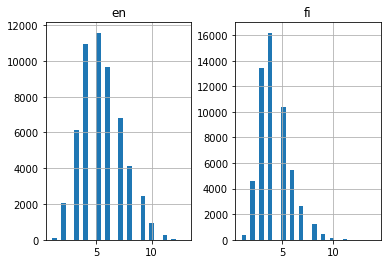

In [59]:
en_l = [len(get_words(i)) for i in en_sentences]
fi_l = [len(get_words(i)) for i in fi_sentences]
        
length_df = pd.DataFrame({'en':en_l, 'fi':fi_l}) 
length_df.hist(bins = 30) 
plt.show()

In [60]:
def tokenization(lines): 
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

### Prepare tokenizers

In [61]:
en_tokenizer = tokenization(en_sentences)
en_vocab_size = len(en_tokenizer.word_index) + 1
en_length = max(en_l)
en_length

13

In [62]:
fi_tokenizer = tokenization(fi_sentences)
fi_vocab_size = len(fi_tokenizer.word_index) + 1
fi_length = max(fi_l)
fi_length

14

In [63]:
def encode_sequences(tokenizer, length, lines):          
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)      
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')        
    return seq

# FI - EN Model

In [64]:
train, test = train_test_split(processed_fi_en, test_size=0.3, random_state= 12)
train

array([['tomilla on ankara päänsärky', 'tom has a severe headache'],
       ['onpa tänään kylmä', 'it sure is cold today'],
       ['voisitko vastata puhelimeen', 'answer the telephone will you'],
       ...,
       ['minkäikäinen teidän siskonne on', 'how old is your sister'],
       ['osaatko laskea kiinaksi kymmeneen',
        'can you count to ten in chinese'],
       ['he kuolivat taistelussa', 'they died in battle']], dtype='<U345')

### Prepare train dataset

In [65]:
trainX = encode_sequences(fi_tokenizer, fi_length, train[:, 0]) 
trainY = encode_sequences(en_tokenizer, en_length, train[:, 1]) 

In [66]:
print(train[:, 0][0])
print(trainX[0])

tomilla on ankara päänsärky
[  32    1 2242 5627    0    0    0    0    0    0    0    0    0    0]


In [67]:
print(train[:, 1][0])
print(trainY[0])

tom has a severe headache
[   1   38    6 3428 1185    0    0    0    0    0    0    0    0]


### Prepare test dataset

In [68]:
testX = encode_sequences(fi_tokenizer, fi_length, test[:, 0]) 
testY = encode_sequences(en_tokenizer, en_length, test[:, 1]) 

In [69]:
print(test[:, 0][0])
print(testX[0])

olen ikuinen optimisti
[   11 14739  4571     0     0     0     0     0     0     0     0     0
     0     0]


In [70]:
print(test[:, 1][0])
print(testY[0])

im always optimistic
[ 20 160 777   0   0   0   0   0   0   0   0   0   0]


### Train NMT model

In [71]:
def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,n):   
    model = Sequential()
    model.add(Embedding(in_vocab, n, input_length=in_timesteps,mask_zero=True))
    model.add(LSTM(n))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(n, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [72]:
if os.path.exists(FILENAME):
    print('loading existing model')
    model = load_model(FILENAME)
else:
    model = build_model(fi_vocab_size, en_vocab_size, fi_length, en_length, 512)

    rms = optimizers.RMSprop(lr=0.001) 
    model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

loading existing model


In [73]:
if NEED_TRAIN:
    checkpoint = ModelCheckpoint(FILENAME, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min')
    
    history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=EPOCHS, batch_size=512, validation_split = 0.3, 
                    callbacks=[checkpoint], verbose=1)
    
    print(history)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train','validation'])
    plt.show()

In [74]:
def get_word(n, tokenizer):  
    for word, index in tokenizer.word_index.items():                       
        if index == n: 
            return word 
    return None

In [75]:
def pre_tran(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    return sentence.lower()

In [76]:
def predict(sentence, source_tokenizer, source_len, target_tokenizer):
    sentence = pre_tran(sentence)
    source = encode_sequences(source_tokenizer, source_len, array([sentence])) 
    p = model.predict_classes(source)[0]
    temp = []
    for j in range(len(p)):             
        t = get_word(p[j], target_tokenizer)             
        if j > 0:                 
            if (t == get_word(p[j-1], target_tokenizer)) or (t == None):                       
                 temp.append('')                 
            else:                      
                 temp.append(t)             
        else:                    
            if(t == None):                                   
                 temp.append('')                    
            else:                           
                 temp.append(t)
    return ' '.join(temp).strip()

In [77]:
def translate_fi_en(sentence):
    return predict(sentence, fi_tokenizer, fi_length, en_tokenizer)

In [78]:
translate_fi_en('Soita lääkärille.')

'call the doctor'

In [79]:
translate_fi_en('Hypätkää')

'jump'

In [38]:
preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

In [40]:
preds_text = [] 
for i in preds:        
    temp = []        
    for j in range(len(i)):             
        t = get_word(i[j], en_tokenizer)             
        if j > 0:                 
            if (t==get_word(i[j-1],en_tokenizer))or(t== None):                       
                 temp.append('')                 
            else:                      
                 temp.append(t)             
        else:                    
            if(t == None):                                   
                 temp.append('')                    
            else:                           
                 temp.append(t)        
    preds_text.append(' '.join(temp))

In [81]:
pred_df = pd.DataFrame({'source': test[:,0], 'actual' : test[:,1], 'predicted' : preds_text})

In [93]:
pred_df.sample(10)

,source,actual,predicted
10717,hän on kiva,hes a kind person,he is kind person
15329,tomin vaatteet ovat epämuodikkaat,toms clothes are out of fashion,toms clothes are in of fashion
7988,menimme kävelylle metsään,we went for a walk in the forest,we went at a hotel a
1726,en tylsistytä sinua yksityiskohdilla,i wont bore you with the details,i dont think you with my
14746,jonnekin meidän pitää vetää raja,we have to draw a line somewhere,we need to improve a stamps
6194,otin lainaksi tomin auton,i borrowed toms car,i bought my car
2256,pystyt pian hiihtämään hyvin,you will soon be able to ski well,i can see but fast well
10028,mene kotiin,please go home,go home
11671,ranskalaiset pitävät etanoista,the french like to eat snails,your french is to a pilot
370,minä löydän ne,ill find them,ill pay them
